# RHIRL [1]

In [1]:
import time
import numpy as np
import tensorflow as tf
from collections import defaultdict

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

It's defined using simple rl framework [3]

In [2]:
np.random.seed(0)
tf.set_random_seed(0)
nvmdp = NavigationMDP(width=30, 
                        height=30,
                        goal_locs=[(21,21)],
                        init_loc=(1,1),
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.0,
                        gamma=.99)

value_iter = ValueIteration(nvmdp, sample_rate=100)
_ = value_iter.run_vi()

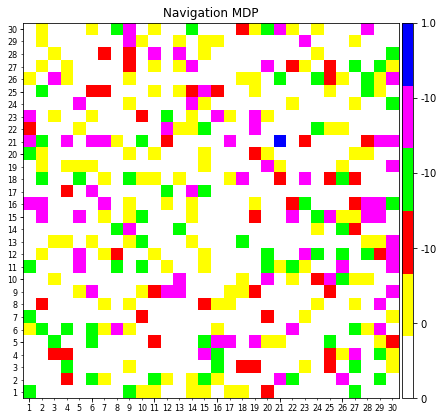

In [3]:
nvmdp.visualize_grid(nvmdp.cells, show_rewards_cbar=True)

In [4]:
def sample_data(nvmdp, n_trajectory):
    """
    Args:
        n_trajectory: number of trajectories to sample

    Returns:
        [[phi(s1), phi(s3), ...], [phi(s1), phi(s3), ...], ...], where phi is one-hot encoded vector 
                of the cell type of a given state  
    """
    A_s = []
    D_mdp_states = []
    
    action_to_idx = {a:i for i,a in enumerate(nvmdp.actions)}
    
    for _ in range(n_trajectory):
        action_seq, state_seq = value_iter.plan(nvmdp.get_random_init_state())
        #print(len(action_seq), len(state_seq))
        D_mdp_states.append(state_seq)
        A_s.append([action_to_idx[a] for a in action_seq])
    return D_mdp_states, A_s

def feature_long_horizon(nvmdp, x, y):
    
    row,col = nvmdp._xy_to_rowcol(x,y)
    if (x, y) in nvmdp.goal_locs:
        return np.zeros(len(nvmdp.cell_types), dtype=np.float32)
    else:
        return np.eye(len(nvmdp.cell_types))[nvmdp.cells[row, col]]
    
def feature_short_horizon(nvmdp, x, y):
    row,col = nvmdp._xy_to_rowcol(x,y)
    return np.hstack((feature_long_horizon(nvmdp, x, y), nvmdp.get_cell_distance_features()[row, col]))

### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

In [5]:
np.random.seed(0)
N_tau = 100
phi_long=lambda mdp_state: feature_long_horizon(nvmdp, mdp_state.x, mdp_state.y)
phi_short=lambda mdp_state: feature_short_horizon(nvmdp, mdp_state.x, mdp_state.y)
D_mdp_states, A_s = sample_data(nvmdp, N_tau)

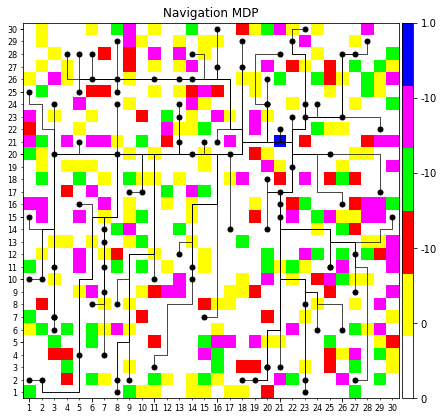

In [6]:
nvmdp.visualize_grid(trajectories=D_mdp_states, show_rewards_cbar=True)

### Features

In [7]:
def states_to_features(states, phi):
    return np.asarray([phi(s) for s in states], dtype=np.float32)

def states_to_coord(states, phi):
    return np.asarray([(s.x, s.y) for s in states], dtype=np.float32)

def get_h_transitions_heap(state, phi, T, actions, h):
    
    frontier = [(state, 0, 0)] # for i, a in enumerate(range(len(actions)))] # BFS frontier: [(state, heap_idx, depth), ...]
    heap = [state] # for a in range(len(actions))]
    parents = [None]
    parent_idx = [-1]
    depths = [0] # for a in range(len(actions))]
    idx = 0
    
    while len(frontier) != 0:
        
        state, heap_idx, d = frontier.pop(0)
        
        if d >= h:
            break
            
        for a in actions:
            state_prime = T(state, a)
            frontier.append((state_prime, idx+1, d+1))
            heap.append(state_prime)
            depths.append(d+1)
            parents.append(state)
            parent_idx.append(heap_idx)
            idx += 1
            
    return states_to_features(heap, phi), np.array(depths, np.int32), parents, np.asarray(parent_idx)

def get_sft(state, phi, T, actions, h):
    
    state_feature_tree, state_depths, _, parent_idx = get_h_transitions_heap(state, phi, T, actions, h)
    # next_state_marker = np.asarray([parent_idx==i for i in range(len(state_feature_tree))], dtype=np.float32)
    tf_sft = np.array([np.where(state_depths.reshape(-1,1) == i, state_feature_tree, np.zeros_like(state_feature_tree)) 
                                for i in range(h)][::-1])
    return tf_sft #, state_feature_tree, state_depths, next_state_marker

def get_training_data(trajectories, phi, T, actions, h):
    
    SFT = {}
    for t_i, traj in enumerate(trajectories):
        for s_i, state in enumerate(traj[:-1]): # in last state no action is taken, so ignore
            if state not in SFT:
                SFT[state] = get_sft(state, phi, T, actions, h)
    heap_size = len(SFT[state][0])
    return SFT, heap_size

def compute_cell_rewards(nvmdp, w_r):
    r_map = np.zeros((nvmdp.height, nvmdp.width), dtype=np.float32)
    for row in range(nvmdp.height):
        for col in range(nvmdp.width):
            x, y = nvmdp._rowcol_to_xy(row, col)
            r_map[row, col] = feature_short_horizon(nvmdp, x, y).dot(w)[0]
    return r_map

### RHIRL TensorFlow Static Graph

In [8]:
tf.reset_default_graph()

def ComputeValue(W_r, V, nA, Pi, V_pad, tf_sft, i):
    
    Phi_S = tf.gather(tf_sft, i)
    R = tf.matmul(Phi_S, W_r, name="R")
    V_prev = tf.expand_dims(V.read(i, name="V_prev"), -1) # For i=0, this will read hth step values which are 0
    Q_h = tf.reshape(tf.squeeze(tf.add(R, tf.multiply(gamma, V_prev), name="Q"))[1:], (-1, nA), "Q_sa_reshaped")
    Pi_h = tf.nn.softmax(Q_h, axis=-1, name="Pi_h")
    V_h = tf.squeeze(tf.pad(tf.reshape(
            tf.reduce_sum(tf.multiply(Q_h, Pi_h), axis=-1, name="V"), [-1,1]), [[0, V_pad], [0, 0]], 'CONSTANT'))
    V = V.write(tf.add(i,1), V_h, name="V_update")
    i = tf.add(i, 1)
    return W_r, V, nA, Pi_h, V_pad, tf_sft, i

def run_RHC(heap_size, nA, W_r, Pi, tf_sft, h):

    V = tf.TensorArray(tf.float32, size=0, dynamic_size=True,
                             clear_after_read=False, infer_shape=False, name="V_array")
    V = V.write(0,  np.zeros(heap_size, dtype=np.float32), name="V_array_0")
    V_pad = tf.constant( int(( nA * (1-nA**(h))/(1-nA) ) - ( nA * (1-nA**(h-1))/(1-nA) )), dtype=tf.int32)

    loop_cond = lambda W_r, V, nA, Pi, V_pad, sft, i: tf.less(i, h-1, name="compute_value_end")
    W_r, V, nA, Pi, V_pad, sft, i = tf.while_loop(loop_cond, ComputeValue, [W_r, V, nA, Pi, V_pad, tf_sft, 0], 
                                              parallel_iterations=1, name="compute_value_loop")
    return V, Pi

def build_rhirl_graph(heap_size, nA, phi_s_dim, h):
    
    g = tf.Graph()
    with g.as_default():
        Pi_init = tf.placeholder(dtype=tf.float32, name="Pi_init")
        tf_sft = tf.placeholder(tf.float32, name="state_feature_tree")
        action_idx = tf.placeholder(tf.int32, name="action_idx")
        lr = tf.placeholder(tf.float32, name="learning_rate")
#         W_r = tf.get_variable("W_r", dtype=tf.float32, initializer=tf.fill((phi_s_dim, 1), 0.)) # good prior
        W_r = tf.get_variable("W_r", dtype=tf.float32, initializer=tf.random_uniform((phi_s_dim, 1), 0, 0.1)) # better?
        V, Pi_out = run_RHC(heap_size, nA, W_r, Pi_init, tf_sft, h)
        log_likelihood = -tf.log(Pi_out[0, action_idx])
        W_grad = tf.gradients(log_likelihood, W_r, name="gradients_w_r")
#         sgd = tf.train.GradientDescentOptimizer(learning_rate=lr)
        adam = tf.train.AdamOptimizer(learning_rate=lr)
        updateWeights = adam.apply_gradients(zip(W_grad, [W_r]), name="update_w_r")
        prob_summary = tf.summary.scalar('P_s_a', Pi_out[0, action_idx])
    return g, Pi_out, W_r, W_grad, updateWeights, prob_summary

### Horizon limited State Feature Tree

- Represent tree of depth h as a heap, where tree is rooted at each (s,a) of D and generated by known dynamics function. We assume R is linearly related to the features of a state so $R=f(\phi(S),W_r)$. For each visited state in the tree, we use features of that state in building the heap (called sft here).

In [9]:
tf.set_random_seed(0)

gamma = 0.9999
nA = len(nvmdp.actions)
phi = phi_short
H = 3

phi_s_dim = len(phi(nvmdp.get_random_init_state()))
SFT3, heap_size = get_training_data(D_mdp_states, phi, nvmdp.transition_func, nvmdp.actions, H)

In [10]:
g1, Pi_out, W_r, W_grad, updateWeights, prob_summary = build_rhirl_graph(heap_size, nA, phi_s_dim, H)
len(g1.get_operations())

422

### Check gradients
Try to overfit the model: provide single sample and optimize over Pi(s_0, a_0)

([<matplotlib.lines.Line2D at 0x1215b4be0>],
 Text(0.5,1,'p(s_0,a)'),
 Text(0.5,0,'iter'),
 Text(0,0.5,'P'))

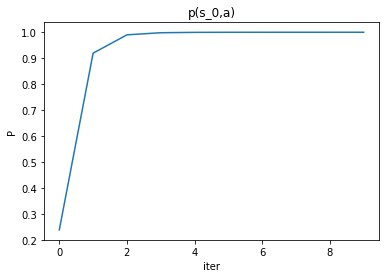

In [11]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('/var/tmp/rhirl/graphs', sess.graph)
    feed_dict = {"state_feature_tree:0": SFT3[D_mdp_states[0][0]], "action_idx:0": 0, 
                 "learning_rate:0":0.5, "Pi_init:0": np.zeros((heap_size, nA), np.float32)}
    p_vals = []
    for i in range(10):
        pi, grad, ugrad = sess.run(fetches=[Pi_out, W_grad, updateWeights], feed_dict=feed_dict)
        p_vals.append(pi[0, 0])

writer.close()
plt.plot(p_vals), plt.title("p(s_0,a)"), plt.xlabel("iter"), plt.ylabel("P")

### RHIRL training H = 3

In [13]:
with tf.Session(graph=g1) as sess:
    
    sess.run(tf.global_variables_initializer())
    # merged_summary = tf.summary.merge([prob_summary])
    p_vals = defaultdict(lambda: [])
    sft_time = 0.
    sft_ticks = 0.
    ep_time = 0.
    n_epochs = 10
    tot_time = 0
    
    cnt = 0
    tot_start = time.time()
    for i in range(n_epochs):
        ep_start = time.time()
        print("Epoch {}:".format(i))
        for t_i, traj in enumerate(D_mdp_states):

            # train_writer = tf.summary.FileWriter("./rhirl/summaries/train", sess.graph)
            for s_i, state in enumerate(traj[:-1]): # in last state no action is taken, so ignore

                feed_dict = {"state_feature_tree:0": SFT3[state], "action_idx:0": A_s[t_i][s_i], 
                                     "learning_rate:0":0.1, "Pi_init:0": np.zeros((heap_size, nA), np.float32)}
                
                start = time.time()
                pi, w, grad, ugrad = sess.run(
                            fetches=[Pi_out, W_r, W_grad, updateWeights], feed_dict=feed_dict)
                sft_time += (time.time()-start)*1000
                sft_ticks += 1
                # print("Compute time per SFT: ", (time.time()-start)*1000)
                t_s_a_key = str(state) + ", a: " + str(A_s[t_i][s_i])
                p_vals[t_s_a_key].append(pi[0, A_s[t_i][s_i]])
                #print("\t P({}, a: {}): {}".format(state, A_s[t_i][s_i], p_vals[t_s_a_key][-1]))
            # train_writer.add_summary(summary, cnt)
            # train_writer.close()
            cnt += 1
            first_state_key = str(traj[0]) + ", a: " + str(A_s[t_i][0])
            # Note: this only prints P(first state, first action) of each trajectory 
            print("\t P({}, a: {}): {:.4f}".format(traj[0], A_s[t_i][s_i], p_vals[first_state_key][-1]))
        ep_time += (time.time()-ep_start)*1000
        # print("Epoch time: ", (time.time()-ep_start)*1000)
    tot_time += (time.time()-tot_start)*1000

Epoch 0:
	 P(s: (18,2), a: 2): 0.2569
	 P(s: (3,20), a: 3): 0.5168
	 P(s: (13,12), a: 3): 0.1202
	 P(s: (16,30), a: 3): 0.2467
	 P(s: (5,16), a: 3): 0.1729
	 P(s: (16,27), a: 3): 0.3784
	 P(s: (3,6), a: 3): 0.8263
	 P(s: (11,10), a: 3): 0.2254
	 P(s: (7,14), a: 3): 0.1947
	 P(s: (24,6), a: 2): 0.3926
	 P(s: (2,2), a: 3): 0.3803
	 P(s: (14,26), a: 3): 0.6647
	 P(s: (29,22), a: 2): 0.1593
	 P(s: (11,3), a: 3): 0.4026
	 P(s: (18,27), a: 3): 0.1759
	 P(s: (3,24), a: 3): 0.1922
	 P(s: (8,8), a: 3): 0.1105
	 P(s: (3,7), a: 3): 0.3491
	 P(s: (8,25), a: 3): 0.4144
	 P(s: (5,21), a: 3): 0.2430
	 P(s: (22,23), a: 2): 0.4619
	 P(s: (27,9), a: 2): 0.1981
	 P(s: (21,16), a: 2): 0.3592
	 P(s: (21,17), a: 2): 0.3062
	 P(s: (21,3), a: 2): 0.2018
	 P(s: (20,3), a: 2): 0.3624
	 P(s: (20,18), a: 2): 0.5628
	 P(s: (26,23), a: 2): 0.3532
	 P(s: (5,4), a: 3): 0.3535
	 P(s: (15,7), a: 3): 0.3405
	 P(s: (16,21), a: 3): 0.2490
	 P(s: (18,29), a: 3): 0.4219
	 P(s: (20,24), a: 3): 0.2774
	 P(s: (20,24), a: 3): 0

In [14]:
len([n.name for n in g1.as_graph_def().node])

425

In [15]:
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(tot_time, sft_time / sft_ticks, ep_time / n_epochs))

Total: 24932.446002960205 ms, SFT compute: 1.384751402508227 ms, Epoch time: 2493.242859840393 ms


In [16]:
cell_rewards = compute_cell_rewards(nvmdp, w)
print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
         [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

cell, true, obtained


[('empty', 0, -2.95),
 ('yellow', 0, -5.59),
 ('red', -10, -20.96),
 ('green', -10, -13.76),
 ('purple', -10, -18.14)]

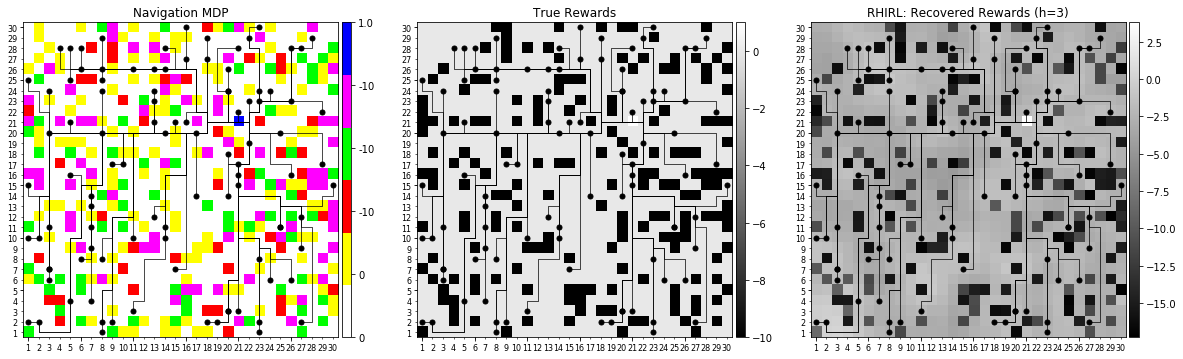

In [17]:
plt.figure(figsize=(20,12)) 
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_mdp_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="132", title="True Rewards", new_fig=False)
nvmdp.visualize_grid(cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="133", new_fig=False, title="RHIRL: Recovered Rewards (h={})".format(H))

## H = 6

In [18]:
tf.set_random_seed(0)

gamma = 0.9999
nA = len(nvmdp.actions)
phi = phi_short
H = 6

phi_s_dim = len(phi(nvmdp.get_random_init_state()))
SFT6, heap_size = get_training_data(D_mdp_states, phi, nvmdp.transition_func, nvmdp.actions, H)

In [19]:
g6, Pi_out, W_r, W_grad, updateWeights, prob_summary = build_rhirl_graph(heap_size, nA, phi_s_dim, H)
len(g6.get_operations())

422

In [21]:
with tf.Session(graph=g6) as sess:
    
    sess.run(tf.global_variables_initializer())
    # merged_summary = tf.summary.merge([prob_summary])
    p_vals = defaultdict(lambda: [])
    sft_time = 0.
    sft_ticks = 0.
    ep_time = 0.
    n_epochs = 10
    tot_time = 0
    
    cnt = 0
    tot_start = time.time()
    for i in range(n_epochs):
        ep_start = time.time()
        print("Epoch {}:".format(i))
        for t_i, traj in enumerate(D_mdp_states):

            # train_writer = tf.summary.FileWriter("./rhirl/summaries/train", sess.graph)
            for s_i, state in enumerate(traj[:-1]): # in last state no action is taken, so ignore

                feed_dict = {"state_feature_tree:0": SFT6[state], "action_idx:0": A_s[t_i][s_i], 
                                     "learning_rate:0":0.01, "Pi_init:0": np.zeros((heap_size, nA), np.float32)}
                
                start = time.time()
                pi, w, grad, ugrad = sess.run(
                            fetches=[Pi_out, W_r, W_grad, updateWeights], feed_dict=feed_dict)
                sft_time += (time.time()-start)*1000
                sft_ticks += 1
                # print("Compute time per SFT: ", (time.time()-start)*1000)
                t_s_a_key = str(state) + ", a: " + str(A_s[t_i][s_i])
                p_vals[t_s_a_key].append(pi[0, A_s[t_i][s_i]])
                #print("\t P({}, a: {}): {}".format(state, A_s[t_i][s_i], p_vals[t_s_a_key][-1]))
            # train_writer.add_summary(summary, cnt)
            # train_writer.close()
            cnt += 1
            first_state_key = str(traj[0]) + ", a: " + str(A_s[t_i][0])
            # Note: this only prints P(first state, first action) of each trajectory 
            print("\t P({}, a: {}): {:.4f}".format(traj[0], A_s[t_i][s_i], p_vals[first_state_key][-1]))
        ep_time += (time.time()-ep_start)*1000
        # print("Epoch time: ", (time.time()-ep_start)*1000)
    tot_time += (time.time()-tot_start)*1000

Epoch 0:
	 P(s: (18,2), a: 2): 0.2453
	 P(s: (3,20), a: 3): 0.3702
	 P(s: (13,12), a: 3): 0.2146
	 P(s: (16,30), a: 3): 0.2595
	 P(s: (5,16), a: 3): 0.1868
	 P(s: (16,27), a: 3): 0.2745
	 P(s: (3,6), a: 3): 0.3189
	 P(s: (11,10), a: 3): 0.1702
	 P(s: (7,14), a: 3): 0.2120
	 P(s: (24,6), a: 2): 0.3432
	 P(s: (2,2), a: 3): 0.3112
	 P(s: (14,26), a: 3): 0.3674
	 P(s: (29,22), a: 2): 0.1604
	 P(s: (11,3), a: 3): 0.3649
	 P(s: (18,27), a: 3): 0.2698
	 P(s: (3,24), a: 3): 0.3189
	 P(s: (8,8), a: 3): 0.2218
	 P(s: (3,7), a: 3): 0.3479
	 P(s: (8,25), a: 3): 0.2965
	 P(s: (5,21), a: 3): 0.1894
	 P(s: (22,23), a: 2): 0.4611
	 P(s: (27,9), a: 2): 0.1924
	 P(s: (21,16), a: 2): 0.2892
	 P(s: (21,17), a: 2): 0.1957
	 P(s: (21,3), a: 2): 0.3447
	 P(s: (20,3), a: 2): 0.3294
	 P(s: (20,18), a: 2): 0.3191
	 P(s: (26,23), a: 2): 0.2545
	 P(s: (5,4), a: 3): 0.1929
	 P(s: (15,7), a: 3): 0.2111
	 P(s: (16,21), a: 3): 0.1959
	 P(s: (18,29), a: 3): 0.4424
	 P(s: (20,24), a: 3): 0.4790
	 P(s: (20,24), a: 3): 0

In [22]:
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(tot_time, sft_time / sft_ticks, ep_time / n_epochs))

Total: 84283.038854599 ms, SFT compute: 4.724209764940688 ms, Epoch time: 8428.30159664154 ms


In [23]:
len([n.name for n in g1.as_graph_def().node])

425

In [24]:
# plt.figure(figsize=(20,8))
# for i, (k,v) in enumerate(p_vals.items()):
#     plt.plot(v, label= r"$\tau_{}$: ".format(i) + k)
#     plt.xlabel("Training Epochs")
#     plt.ylabel("P")
# plt.title(r"P($s_0$,$a_0$)")
# plt.legend()

In [25]:
w

array([[-2.1150422e+00],
       [-3.9866257e+00],
       [-1.6485899e+01],
       [-9.4367685e+00],
       [-9.9133883e+00],
       [ 1.9434988e+00],
       [ 1.6171783e-01],
       [-1.9938862e-01],
       [-8.1187012e-03],
       [ 1.2454609e-01]], dtype=float32)

In [26]:
cell_rewards = compute_cell_rewards(nvmdp, w)
print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
         [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

cell, true, obtained


[('empty', 0, -2.12),
 ('yellow', 0, -3.99),
 ('red', -10, -16.49),
 ('green', -10, -9.44),
 ('purple', -10, -9.91)]

### Recovered Rewards

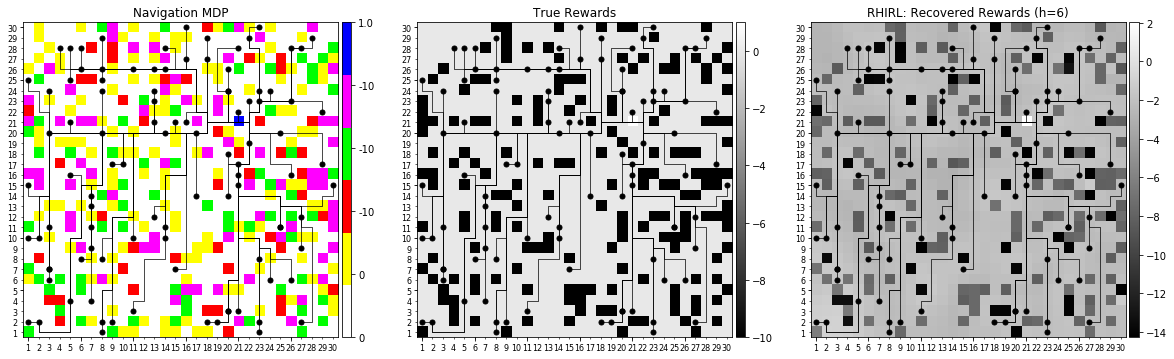

In [27]:
plt.figure(figsize=(20,12)) 
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_mdp_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="132", title="True Rewards", new_fig=False)
nvmdp.visualize_grid(cell_rewards, trajectories=D_mdp_states, 
               cmap=plt.cm.gray, subplot_str="133", new_fig=False, title="RHIRL: Recovered Rewards (h={})".format(H))